In [1]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from coropy.growth_models import GrowthCOVIDModel

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)

epidemics_start_date = dt.datetime(2020, 2, 25)
date_list = [epidemics_start_date + dt.timedelta(days=i) for i in range(confirmed_cases.size)]
# full data dataframe
df = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
    'daily_tests': daily_tests})
# first wave dataframe
eff_date = dt.datetime(2020, 6, 1)
df_critical = df[df.date < eff_date]
df_critical.reset_index(drop=True, inplace=True)

## Assuming input data intrinsically noiseless

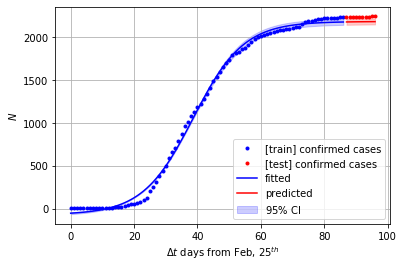

In [3]:
cumulative_positive = df_critical.confirmed_cases.values
daily_positive = np.concatenate((np.array([cumulative_positive[0]]), np.diff(cumulative_positive)))
cumulative_removed = df_critical.recovered_cases.values + df_critical.death_cases.values
daily_tests = df_critical.daily_tests.values

days_to_predict = 10
y_train, y_test = cumulative_positive[:-days_to_predict], cumulative_positive[-days_to_predict:]

# instantiate a model
model = GrowthCOVIDModel('logistic', normalize=True, calc_ci=True)

# train a model
model.fit(y_train)

# obtain fitted values
x_fitted, y_fitted = model.get_fitted

# obtain predictions
x_predicted, y_predicted = model.predict(days_to_predict)

# visualize
fig, ax = plt.subplots()
ax.plot(x_fitted, y_train, 'b.', label='[train] confirmed cases')
ax.plot(x_predicted, y_test, 'r.', label='[test] confirmed cases')
ax.plot(x_fitted, y_fitted[1], 'b-', label='fitted')
ax.fill_between(x_fitted, y_fitted[0], y_fitted[2], color='b', alpha=0.2, label='$95\%$ CI')
ax.plot(x_predicted, y_predicted[1], 'r-', label='predicted')
ax.fill_between(x_predicted, y_predicted[0], y_predicted[2], color='r', alpha=0.2)

ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()

## Estimating standard error in the data using sensitivity and specificity

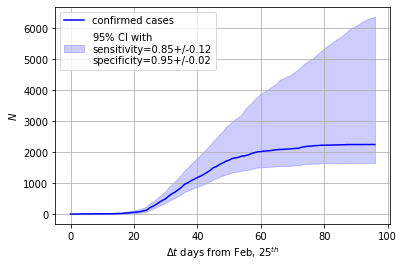

In [4]:
# Ref: BMJ 2020;369:m1808
pcr_sens = 0.85
pcr_spec = 0.95

# calculate standard error in sensitivity and obtain the number on cumulative true positives (95% CI)
std_sens_err = np.sqrt(np.divide(
    (1 - pcr_sens) * pcr_sens, 
    daily_positive, 
    out=np.zeros(daily_positive.shape, dtype=float), 
    where=daily_positive!=0,))
sens_lb_ci = pcr_sens - 1.96 * std_sens_err
tp_lb_ci = sens_lb_ci * daily_positive
cumulative_tp_lb_ci = np.cumsum(tp_lb_ci)

# calculate standard error in specificity and obtain the number on cumulative true positives (95% CI)
daily_tests = np.concatenate((np.array([daily_tests[0]]),
    daily_tests[:-1]))
daily_negative = daily_tests - daily_positive
std_spec_err = np.sqrt(np.divide(
    (1 - pcr_spec) * pcr_spec,
    daily_negative,
    out=np.zeros(daily_negative.shape, dtype=float), 
    where=daily_negative!=0,))
spec_ub_ci = pcr_spec - 1.96 * std_spec_err
tn_ci = spec_ub_ci * daily_negative
fn_ci = daily_negative - tn_ci
tp_ub_ci = fn_ci + daily_positive
cumulative_tp_ub_ci = np.cumsum(tp_ub_ci)

# visualize input data inside of cofindence intervals (sensitivity -> lower bound; specificity -> upper bound)
days = list(range(cumulative_positive.size))
fig, ax = plt.subplots()
ax.plot(days, cumulative_positive, 'b-', label='confirmed cases')
ax.fill_between(days, cumulative_tp_lb_ci, cumulative_tp_ub_ci, color='b', alpha=0.2,
                label=f'$95\%$ CI with\nsensitivity={pcr_sens}+/-{round(np.mean(std_sens_err), 2)}\nspecificity={pcr_spec}+/-{round(np.mean(std_spec_err), 2)}')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend(loc='upper left')
ax.grid()
plt.show()

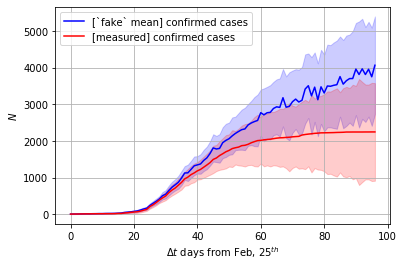

In [5]:
# calculate dispesion for each day in the number of confirmed positive infections in range [lower bound, upper bound]
y_data_disp = np.asarray([np.random.uniform(cumulative_tp_lb_ci[i], cumulative_tp_ub_ci[i], 100) for i in range(cumulative_positive.size)])

# expected value and standard error for each day
y_data_means = y_data_disp.mean(axis=1)
y_data_stds = y_data_disp.std(axis=1)

# visualize "fake" mean and actual measured expectation in the number of infections
days = list(range(cumulative_positive.size))
fig, ax = plt.subplots()
ax.plot(days, y_data_means, 'b-', label='[`fake` mean] confirmed cases')
ax.plot(days, cumulative_positive, 'r-', label='[measured] confirmed cases')
ax.fill_between(days, y_data_means - y_data_stds, y_data_means + y_data_stds, color='b', alpha=0.2)
ax.fill_between(days, cumulative_positive - y_data_stds, cumulative_positive + y_data_stds, color='r', alpha=0.2)
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend(loc='upper left')
ax.grid()
plt.show()

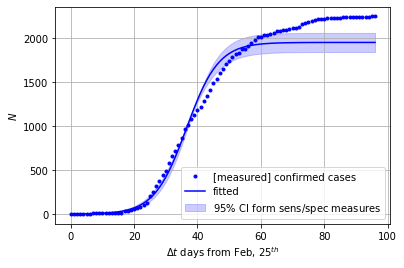

In [6]:
# modeling with input uncertainty in data
model = GrowthCOVIDModel('logistic', normalize=True, calc_ci=True, spread=y_data_stds)
model.fit(cumulative_positive)
x_fitted, y_fitted = model.get_fitted

# visualize
fig, ax = plt.subplots()
ax.plot(x_fitted, cumulative_positive, 'b.', label='[measured] confirmed cases')
ax.plot(x_fitted, y_fitted[1], 'b-', label='fitted')
ax.fill_between(x_fitted, y_fitted[0], y_fitted[2], color='b', alpha=0.2, label='$95\%$ CI form sens/spec measures')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()